In [ ]:
import pyro
import torch
import normflows as nf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import yaml
import corner
import random
import pandas as pd
from collections import defaultdict
import numpy as np
mpl.rcParams["figure.dpi"] = 100

from grad_june import Runner

#torch.autograd.detect_anomaly(check_nan=True)

In [2]:
device = "cpu"

In [3]:
def set_random_seed(seed=999):
    """
    Sets global seeds for testing in numpy, random, and numbaized numpy.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return
#set_random_seed()

In [4]:
def plot_posterior(nfm, param_names, lims=(0,2)):
    posteriors = nfm.sample(10000)
    samples = posteriors[0].cpu().detach().numpy()
    samples = np.where(~np.isnan(samples), samples, 0)
    samples = np.where(~np.isinf(samples), samples, 0)
    samples = np.where(np.abs(samples) < 5, samples, 0)
    f = corner.corner(samples, 
                      labels = param_names, 
                      smooth=2, 
                      show_titles=True,
                      bins=30,
                      range = [lims for i in range(len(param_names))])
    #f.savefig(f"./flow_results/posteriors/posterior_{it:03d}.png", dpi=150, facecolor='white')
    return

In [5]:
data_df = pd.read_csv("../deaths_by_lad.csv")
data_df = data_df.loc[data_df.area_name == "Camden"]
data_df = data_df.groupby("date").sum()["daily_deaths"].to_frame()
data_df.index = pd.to_datetime(data_df.index)
data_df = data_df.loc["2020-03-15":"2020-05-31"].cumsum()
data_df

,daily_deaths
date,
2020-03-15,1
2020-03-16,1
2020-03-17,1
2020-03-18,1
2020-03-19,2
...,...
2020-05-27,126
2020-05-28,126
2020-05-29,126


In [6]:
#params = yaml.safe_load(open("../configs/june.yaml"))
params_to_calibrate = ["household", "school", "company", "university", "log_fraction_initial_cases"]
n_params = len(params_to_calibrate)
params = yaml.safe_load(open("../configs/best_run.yaml"))
params["timer"]["total_days"] = len(data_df) - 1
params["timer"]["initial_day"] = "2020-03-15"
params["system"]["device"] = device
#params["data_path"] = "/cosma/home/dp004/dc-quer1/gradabm-june/test/data/data.pkl"
params["data_path"] = "/cosma7/data/dp004/dc-quer1/torch_june_worlds/data_camden.pkl"
runner = Runner.from_parameters(params)
runner()
test_deaths = runner.data['results']['daily_deaths']

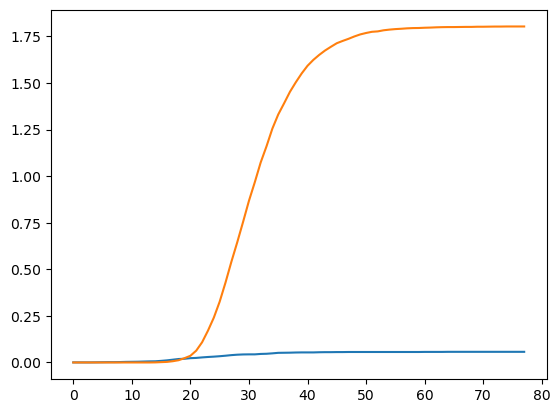

In [7]:
true_data = torch.tensor(data_df.values, device=device).flatten() / runner.n_agents * 100
plt.plot(true_data.cpu())
plt.plot(test_deaths / runner.n_agents * 100)

In [8]:
prior = torch.distributions.Normal(torch.ones(n_params, device=device), torch.ones(n_params, device=device))

/cosma/home/dp004/dc-quer1/.conda/envs/ml/lib/python3.9/site-packages/normflows/flows/mixing.py:437: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  outputs, _ = torch.triangular_solve(


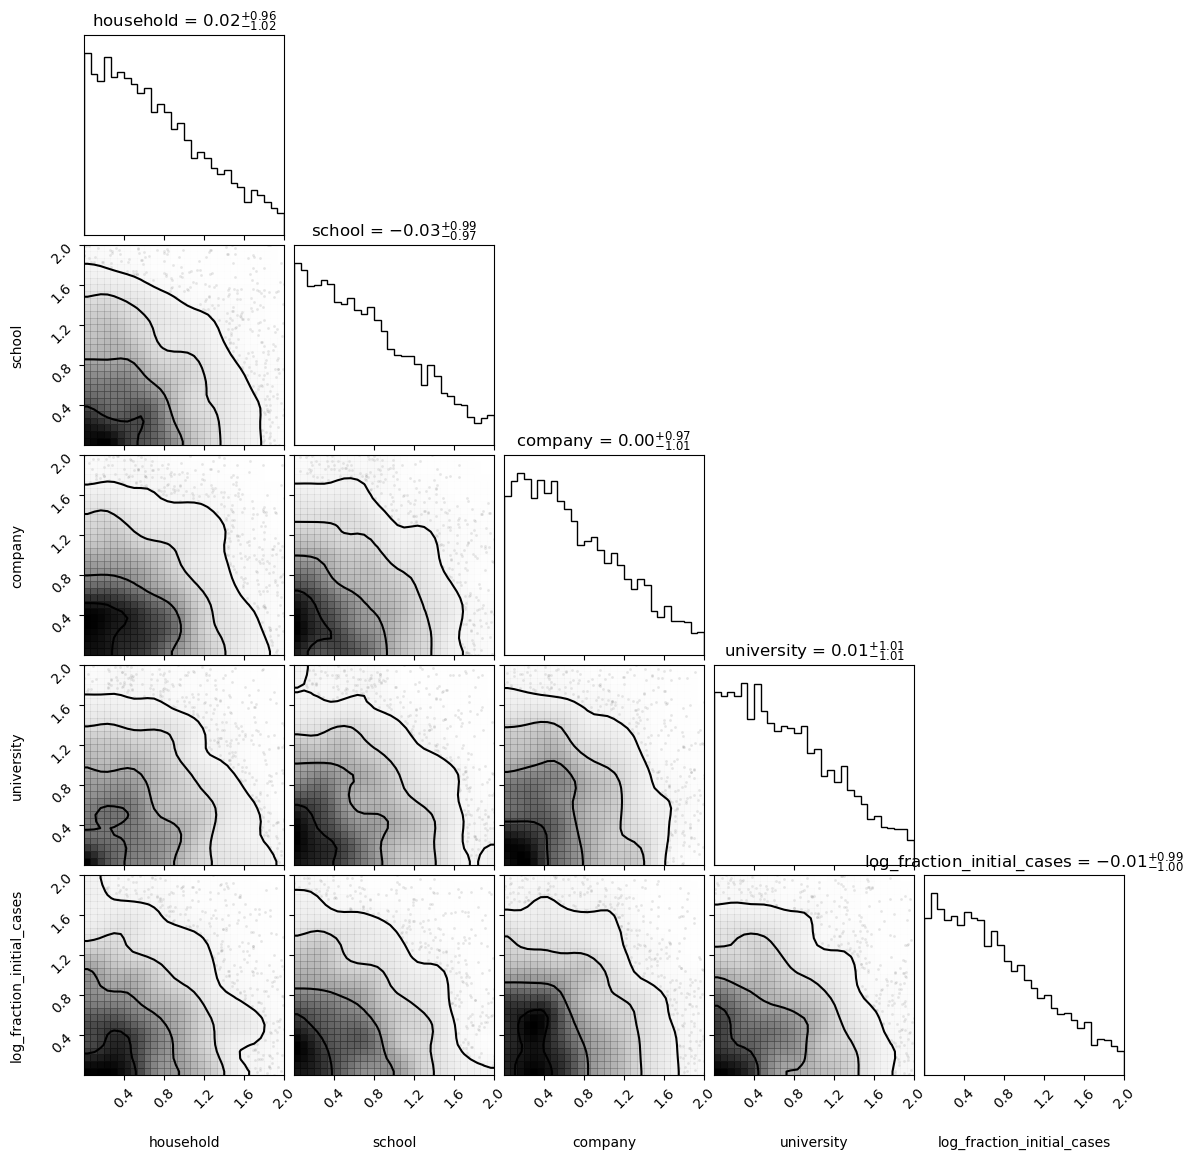

In [9]:
# Set up model

# Define flows
K = 8

latent_size = n_params
hidden_units = 32
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(n_params, trainable=False)

# Construct flow model
flow = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
flow = flow.to(device)

plot_posterior(flow, param_names = params_to_calibrate)
plt.show()

In [10]:
def run_model(runner, sample):
    #print(sample)
    sample = sample.flatten()
    for (j, name) in enumerate(params_to_calibrate):
        if name == "log_fraction_initial_cases":
            runner.log_fraction_initial_cases = torch.minimum(torch.tensor(0.0), sample[j])
            print(sample[j])
        else:
            runner.model.infection_networks.networks[name].log_beta = sample[j]
    _, _ = runner()
    daily_deaths = runner.data["results"]["daily_deaths"] / runner.n_agents * 100
    return daily_deaths

def get_forecast_score(flow, true_data, loss_fn, n_samples=5):
    loss = 0.0
    for i in range(n_samples):
        sample, lp = flow.sample()
        daily_deaths = run_model(runner, sample)
        print(daily_deaths)
        print(true_data)
        print("--")
        loss += loss_fn(daily_deaths, true_data)
    return loss / n_samples

def get_regularisation(flow, n_samples=5):
    samples, flow_lps = flow.sample(n_samples)
    prior_lps = prior.log_prob(samples).sum(1)
    kl = torch.mean(flow_lps - prior_lps)
    return kl


In [11]:
losses = defaultdict(list)
best_loss = np.inf

In [ ]:
# Train model

parameters_to_optimize = list(flow.parameters())
print(sum([len(a) for a in parameters_to_optimize]))
optimizer = torch.optim.Adam(parameters_to_optimize, lr=1e-3)
loss_fn = torch.nn.MSELoss(reduction="mean")


n_epochs = 10000
n_samples_per_epoch = 10
n_samples_reg = 10


w = 0.0 #torch.tensor(1.0, requires_grad=True)

iterator = tqdm(range(n_epochs))

for it in iterator:
    optimizer.zero_grad()
    forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
    loss = forecast_loss  + w * reglrise_loss
    losses["forecast_train"].append(forecast_loss.item())
    losses["reglrise_train"].append(reglrise_loss.item())
    #print(loss)
    if torch.isnan(loss):
        print("loss is nan!")
        break
    loss.backward()

    optimizer.step()
    if loss.item() < best_loss:
        torch.save(flow.state_dict(), "./best_model_data.pth")
        best_loss = loss.item()
    
    #with torch.no_grad():
    #    val_forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    #    val_reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
    #    val_loss = val_forecast_loss + w * val_reglrise_loss
    #    
    #    losses["forecast_val"].append(val_forecast_loss.item())
    #    losses["reglrise_val"].append(val_reglrise_loss.item())
#
    #    if val_loss.item() < best_loss:
    #        torch.save(flow.state_dict(), "./best_model_data.pth")
    #        best_loss = val_loss.item()
    #    iterator.set_postfix({"fl":forecast_loss.item(), 
    #                          "rl":reglrise_loss.item(), 
    #                          "val loss":val_loss.item(), 
    #                          "best val loss":best_loss})
    df = pd.DataFrame(losses)
    df.to_csv("./losses_data.csv")

4640


  0%|                                                              | 0/10000 [00:00<?, ?it/s]

tensor(-0.4082, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5385e-04, 4.0846e-03,
        9.9847e-03, 2.2239e-02, 4.2662e-02, 7.1254e-02, 1.2572e-01, 1.9742e-01,
        2.8638e-01, 4.0166e-01, 5.2056e-01, 6.4946e-01, 7.9015e-01, 9.4083e-01,
        1.0924e+00, 1.2263e+00, 1.3570e+00, 1.4814e+00, 1.5916e+00, 1.6947e+00,
        1.7913e+00, 1.8776e+00, 1.9429e+00, 2.0006e+00, 2.0473e+00, 2.0891e+00,
        2.1231e+00, 2.1567e+00, 2.1821e+00, 2.1993e+00, 2.2198e+00, 2.2357e+00,
        2.2479e+00, 2.2602e+00, 2.2711e+00, 2.2806e+00, 2.2888e+00, 2.2960e+00,
        2.3001e+00, 2.3055e+00, 2.3092e+00, 2.3114e+00, 2.3128e+00, 2.3151e+00,
        2.3183e+00, 2.3192e+00, 2.3196e+00, 2.3196e+00, 2.3196e+00, 2.3214e+00,
        2.3214e+00, 2.3219e+00, 2.3232e+00, 2.3232e+00, 2.3237e+00, 2.3260e+00,
        2.3260e+00, 2.3260e+00, 2.3260e+00, 2.3260e+00, 2.3260e+00, 2.3260e+0

  0%|                                                | 1/10000 [06:58<1161:02:51, 418.02s/it]

tensor(0.9726, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0770e-04, 2.7231e-03, 9.0770e-03,
        1.9515e-02, 3.9485e-02, 8.3508e-02, 1.4024e-01, 2.2420e-01, 3.3131e-01,
        4.8380e-01, 6.4083e-01, 8.0967e-01, 9.8394e-01, 1.1623e+00, 1.3429e+00,
        1.4968e+00, 1.6388e+00, 1.7723e+00, 1.8998e+00, 2.0169e+00, 2.1177e+00,
        2.2016e+00, 2.2733e+00, 2.3446e+00, 2.4031e+00, 2.4403e+00, 2.4803e+00,
        2.5148e+00, 2.5406e+00, 2.5688e+00, 2.5838e+00, 2.5996e+00, 2.6151e+00,
        2.6264e+00, 2.6378e+00, 2.6455e+00, 2.6527e+00, 2.6586e+00, 2.6609e+00,
        2.6695e+00, 2.6741e+00, 2.6754e+00, 2.6777e+00, 2.6795e+00, 2.6809e+00,
        2.6832e+00, 2.6859e+00, 2.6868e+00, 2.6881e+00, 2.6886e+00, 2.6895e+00,
        2.6904e+00, 2.6904e+00, 2.6904e+00, 2.6913e+00, 2.6913e+00, 2.6918e+00,
        2.6918e+00, 2.6918e+00, 2.6922e+00, 2.6922e+00, 2.6922e+00, 2.6922e+00

  0%|                                                | 2/10000 [13:34<1124:55:49, 405.06s/it]

tensor(-0.1629, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5385e-04, 3.6308e-03,
        1.4069e-02, 2.9954e-02, 6.3539e-02, 1.0892e-01, 1.7473e-01, 2.6959e-01,
        3.7715e-01, 5.1058e-01, 6.5036e-01, 8.0195e-01, 9.4673e-01, 1.0824e+00,
        1.2286e+00, 1.3747e+00, 1.4950e+00, 1.6116e+00, 1.7214e+00, 1.8263e+00,
        1.9084e+00, 1.9770e+00, 2.0455e+00, 2.0981e+00, 2.1485e+00, 2.1948e+00,
        2.2257e+00, 2.2579e+00, 2.2801e+00, 2.2960e+00, 2.3110e+00, 2.3301e+00,
        2.3450e+00, 2.3555e+00, 2.3645e+00, 2.3714e+00, 2.3795e+00, 2.3868e+00,
        2.3891e+00, 2.3922e+00, 2.3945e+00, 2.3977e+00, 2.4004e+00, 2.4022e+00,
        2.4054e+00, 2.4063e+00, 2.4099e+00, 2.4122e+00, 2.4145e+00, 2.4149e+00,
        2.4158e+00, 2.4172e+00, 2.4181e+00, 2.4181e+00, 2.4186e+00, 2.4186e+00,
        2.4186e+00, 2.4190e+00, 2.4190e+00, 2.4190e+00, 2.4190e+00, 2.4190e+0

  0%|                                                | 3/10000 [20:32<1142:06:29, 411.28s/it]

tensor(0.2420, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5385e-04, 9.0770e-04, 5.9000e-03,
        1.8154e-02, 4.0392e-02, 8.7139e-02, 1.5113e-01, 2.3645e-01, 3.4629e-01,
        4.8471e-01, 6.2450e-01, 7.7563e-01, 9.3765e-01, 1.1124e+00, 1.2662e+00,
        1.4092e+00, 1.5481e+00, 1.6960e+00, 1.8077e+00, 1.9207e+00, 2.0160e+00,
        2.0936e+00, 2.1680e+00, 2.2261e+00, 2.2824e+00, 2.3287e+00, 2.3732e+00,
        2.4031e+00, 2.4317e+00, 2.4544e+00, 2.4753e+00, 2.4880e+00, 2.5057e+00,
        2.5152e+00, 2.5288e+00, 2.5375e+00, 2.5452e+00, 2.5506e+00, 2.5561e+00,
        2.5615e+00, 2.5661e+00, 2.5692e+00, 2.5747e+00, 2.5779e+00, 2.5797e+00,
        2.5819e+00, 2.5833e+00, 2.5838e+00, 2.5856e+00, 2.5874e+00, 2.5888e+00,
        2.5901e+00, 2.5915e+00, 2.5919e+00, 2.5919e+00, 2.5919e+00, 2.5919e+00,
        2.5928e+00, 2.5933e+00, 2.5942e+00, 2.5942e+00, 2.5947e+00, 2.5947e+00

  0%|                                                | 4/10000 [27:40<1159:39:05, 417.64s/it]

tensor(-0.4333, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8154e-03,
        5.4462e-03, 1.7246e-02, 4.5385e-02, 8.1693e-02, 1.3661e-01, 2.0151e-01,
        2.8275e-01, 3.9122e-01, 5.1875e-01, 6.6353e-01, 8.0286e-01, 9.4582e-01,
        1.0879e+00, 1.2150e+00, 1.3543e+00, 1.4800e+00, 1.5916e+00, 1.6910e+00,
        1.7823e+00, 1.8508e+00, 1.9193e+00, 1.9797e+00, 2.0237e+00, 2.0632e+00,
        2.0963e+00, 2.1276e+00, 2.1526e+00, 2.1721e+00, 2.1916e+00, 2.2057e+00,
        2.2229e+00, 2.2402e+00, 2.2493e+00, 2.2588e+00, 2.2679e+00, 2.2738e+00,
        2.2779e+00, 2.2833e+00, 2.2878e+00, 2.2910e+00, 2.2947e+00, 2.2974e+00,
        2.2983e+00, 2.2992e+00, 2.3006e+00, 2.3019e+00, 2.3028e+00, 2.3028e+00,
        2.3037e+00, 2.3046e+00, 2.3046e+00, 2.3051e+00, 2.3055e+00, 2.3065e+00,
        2.3069e+00, 2.3069e+00, 2.3069e+00, 2.3069e+00, 2.3069e+00, 2.3074e+0

  0%|                                                | 5/10000 [34:57<1179:34:26, 424.86s/it]

tensor(0.7091, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.5385e-04, 9.0770e-04, 1.3615e-03, 4.5385e-03,
        1.6792e-02, 4.2662e-02, 8.3054e-02, 1.3979e-01, 2.2556e-01, 3.3857e-01,
        4.7654e-01, 6.3675e-01, 7.9923e-01, 9.7305e-01, 1.1410e+00, 1.3212e+00,
        1.4809e+00, 1.6261e+00, 1.7573e+00, 1.8871e+00, 1.9947e+00, 2.0891e+00,
        2.1717e+00, 2.2384e+00, 2.3069e+00, 2.3573e+00, 2.4049e+00, 2.4453e+00,
        2.4780e+00, 2.5130e+00, 2.5447e+00, 2.5656e+00, 2.5797e+00, 2.5928e+00,
        2.6078e+00, 2.6160e+00, 2.6301e+00, 2.6387e+00, 2.6441e+00, 2.6482e+00,
        2.6537e+00, 2.6555e+00, 2.6586e+00, 2.6618e+00, 2.6655e+00, 2.6659e+00,
        2.6677e+00, 2.6691e+00, 2.6704e+00, 2.6723e+00, 2.6741e+00, 2.6745e+00,
        2.6763e+00, 2.6763e+00, 2.6763e+00, 2.6773e+00, 2.6782e+00, 2.6782e+00,
        2.6782e+00, 2.6782e+00, 2.6782e+00, 2.6786e+00, 2.6786e+00, 2.6786e+00

  0%|                                                | 6/10000 [42:07<1183:52:53, 426.45s/it]

tensor(2.1726, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5385e-04, 1.3615e-03, 7.2616e-03,
        1.9515e-02, 4.3569e-02, 8.5777e-02, 1.4977e-01, 2.4326e-01, 3.6308e-01,
        4.8516e-01, 6.2858e-01, 8.0059e-01, 9.5353e-01, 1.1260e+00, 1.2985e+00,
        1.4605e+00, 1.6048e+00, 1.7423e+00, 1.8653e+00, 1.9824e+00, 2.0800e+00,
        2.1694e+00, 2.2434e+00, 2.3114e+00, 2.3609e+00, 2.4113e+00, 2.4585e+00,
        2.4857e+00, 2.5134e+00, 2.5402e+00, 2.5583e+00, 2.5710e+00, 2.5842e+00,
        2.5947e+00, 2.6060e+00, 2.6110e+00, 2.6169e+00, 2.6219e+00, 2.6269e+00,
        2.6301e+00, 2.6332e+00, 2.6369e+00, 2.6378e+00, 2.6396e+00, 2.6414e+00,
        2.6441e+00, 2.6455e+00, 2.6464e+00, 2.6491e+00, 2.6496e+00, 2.6509e+00,
        2.6514e+00, 2.6518e+00, 2.6523e+00, 2.6532e+00, 2.6537e+00, 2.6550e+00,
        2.6555e+00, 2.6564e+00, 2.6568e+00, 2.6568e+00, 2.6568e+00, 2.6568e+00

  0%|                                                | 7/10000 [49:19<1189:08:48, 428.39s/it]

tensor(0.0223, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3615e-03, 7.2616e-03,
        1.5431e-02, 3.6308e-02, 7.3070e-02, 1.3979e-01, 2.2239e-01, 3.4583e-01,
        4.7200e-01, 6.2359e-01, 7.7790e-01, 9.4718e-01, 1.1010e+00, 1.2531e+00,
        1.4124e+00, 1.5540e+00, 1.6756e+00, 1.8009e+00, 1.9189e+00, 2.0174e+00,
        2.0922e+00, 2.1685e+00, 2.2288e+00, 2.2906e+00, 2.3400e+00, 2.3723e+00,
        2.4081e+00, 2.4304e+00, 2.4526e+00, 2.4726e+00, 2.4925e+00, 2.5111e+00,
        2.5220e+00, 2.5316e+00, 2.5379e+00, 2.5443e+00, 2.5524e+00, 2.5565e+00,
        2.5624e+00, 2.5661e+00, 2.5688e+00, 2.5724e+00, 2.5747e+00, 2.5760e+00,
        2.5774e+00, 2.5783e+00, 2.5792e+00, 2.5810e+00, 2.5819e+00, 2.5828e+00,
        2.5842e+00, 2.5842e+00, 2.5847e+00, 2.5865e+00, 2.5865e+00, 2.5865e+00,
        2.5869e+00, 2.5878e+00, 2.5878e+00, 2.5883e+00, 2.5883e+00, 2.5883e+00

  0%|                                                | 8/10000 [56:29<1189:56:43, 428.72s/it]

tensor(-1.2858, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.5385e-04, 1.8154e-03, 6.8077e-03, 1.1346e-02, 2.1331e-02, 3.5854e-02,
        5.6277e-02, 8.3962e-02, 1.1845e-01, 1.6112e-01, 2.2420e-01, 2.9137e-01,
        3.7216e-01, 4.5476e-01, 5.5006e-01, 6.3675e-01, 7.3342e-01, 8.1012e-01,
        8.9907e-01, 9.6806e-01, 1.0343e+00, 1.0942e+00, 1.1541e+00, 1.1995e+00,
        1.2340e+00, 1.2690e+00, 1.2989e+00, 1.3266e+00, 1.3552e+00, 1.3752e+00,
        1.3938e+00, 1.4083e+00, 1.4192e+00, 1.4278e+00, 1.4355e+00, 1.4401e+00,
        1.4473e+00, 1.4523e+00, 1.4573e+00, 1.4605e+00, 1.4618e+00, 1.4632e+00,
        1.4655e+00, 1.4659e+00, 1.4687e+00, 1.4696e+00, 1.4714e+00, 1.4718e+00,
        1.4723e+00, 1.4741e+00, 1.4741e+00, 1.4741e+00, 1.4741e+00, 1.4741e+00,
        1.4746e+00, 1.4750e+00, 1.4755e+00, 1.4755e+00, 1.4759e+00, 1.4759e+0

  0%|                                              | 9/10000 [1:03:40<1192:21:57, 429.64s/it]

tensor(-1.1914, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5385e-04,
        2.7231e-03, 5.4462e-03, 8.1693e-03, 1.3162e-02, 2.5869e-02, 4.2662e-02,
        8.1239e-02, 1.2390e-01, 1.8290e-01, 2.4462e-01, 3.2722e-01, 4.1255e-01,
        5.1693e-01, 6.0089e-01, 7.1027e-01, 8.2963e-01, 9.4310e-01, 1.0357e+00,
        1.1242e+00, 1.2131e+00, 1.2971e+00, 1.3656e+00, 1.4360e+00, 1.4986e+00,
        1.5463e+00, 1.5953e+00, 1.6370e+00, 1.6688e+00, 1.6978e+00, 1.7246e+00,
        1.7419e+00, 1.7646e+00, 1.7786e+00, 1.7918e+00, 1.8013e+00, 1.8059e+00,
        1.8095e+00, 1.8177e+00, 1.8199e+00, 1.8208e+00, 1.8236e+00, 1.8267e+00,
        1.8295e+00, 1.8313e+00, 1.8322e+00, 1.8335e+00, 1.8340e+00, 1.8349e+00,
        1.8363e+00, 1.8372e+00, 1.8372e+00, 1.8376e+00, 1.8381e+00, 1.8385e+00,
        1.8390e+00, 1.8394e+00, 1.8394e+00, 1.8394e+00, 1.8394e+00, 1.8394e+0

  0%|                                             | 10/10000 [1:10:49<1191:05:09, 429.22s/it]

tensor(0.3402, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5385e-04, 2.2692e-03, 5.4462e-03,
        1.5431e-02, 4.4931e-02, 8.6231e-02, 1.4841e-01, 2.3736e-01, 3.5309e-01,
        4.9923e-01, 6.5763e-01, 8.1511e-01, 9.7396e-01, 1.1410e+00, 1.3071e+00,
        1.4732e+00, 1.6202e+00, 1.7469e+00, 1.8594e+00, 1.9702e+00, 2.0573e+00,
        2.1467e+00, 2.2157e+00, 2.2819e+00, 2.3273e+00, 2.3664e+00, 2.4022e+00,
        2.4353e+00, 2.4662e+00, 2.4866e+00, 2.5039e+00, 2.5238e+00, 2.5425e+00,
        2.5570e+00, 2.5670e+00, 2.5715e+00, 2.5779e+00, 2.5815e+00, 2.5869e+00,
        2.5915e+00, 2.5965e+00, 2.6006e+00, 2.6033e+00, 2.6051e+00, 2.6074e+00,
        2.6092e+00, 2.6110e+00, 2.6128e+00, 2.6137e+00, 2.6164e+00, 2.6169e+00,
        2.6173e+00, 2.6187e+00, 2.6192e+00, 2.6192e+00, 2.6192e+00, 2.6192e+00,
        2.6192e+00, 2.6192e+00, 2.6196e+00, 2.6196e+00, 2.6196e+00, 2.6196e+00

  0%|                                             | 11/10000 [1:18:01<1193:49:38, 430.25s/it]

tensor(-1.2653, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0770e-04,
        1.3615e-03, 3.1769e-03, 7.2616e-03, 1.0892e-02, 2.0423e-02, 3.5400e-02,
        5.5369e-02, 7.9423e-02, 1.1664e-01, 1.5295e-01, 2.0469e-01, 2.6822e-01,
        3.3857e-01, 4.0982e-01, 4.8471e-01, 5.5914e-01, 6.4356e-01, 7.2797e-01,
        8.0240e-01, 8.7184e-01, 9.2767e-01, 9.8894e-01, 1.0311e+00, 1.0797e+00,
        1.1142e+00, 1.1578e+00, 1.1950e+00, 1.2204e+00, 1.2386e+00, 1.2594e+00,
        1.2803e+00, 1.2962e+00, 1.3089e+00, 1.3175e+00, 1.3243e+00, 1.3302e+00,
        1.3366e+00, 1.3443e+00, 1.3457e+00, 1.3502e+00, 1.3511e+00, 1.3556e+00,
        1.3584e+00, 1.3597e+00, 1.3611e+00, 1.3625e+00, 1.3629e+00, 1.3634e+00,
        1.3638e+00, 1.3656e+00, 1.3665e+00, 1.3670e+00, 1.3670e+00, 1.3670e+00,
        1.3670e+00, 1.3670e+00, 1.3679e+00, 1.3679e+00, 1.3684e+00, 1.3684e+0

  0%|                                             | 12/10000 [1:25:08<1190:57:38, 429.26s/it]

tensor(-1.3530, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5385e-04,
        9.0770e-04, 2.7231e-03, 9.0770e-03, 1.7246e-02, 3.4039e-02, 6.2177e-02,
        9.3493e-02, 1.4342e-01, 2.0832e-01, 2.8093e-01, 3.5763e-01, 4.5612e-01,
        5.7049e-01, 6.8168e-01, 7.9242e-01, 9.1632e-01, 1.0162e+00, 1.1224e+00,
        1.2254e+00, 1.3239e+00, 1.3983e+00, 1.4664e+00, 1.5336e+00, 1.5880e+00,
        1.6398e+00, 1.6801e+00, 1.7183e+00, 1.7469e+00, 1.7732e+00, 1.7895e+00,
        1.8136e+00, 1.8326e+00, 1.8449e+00, 1.8590e+00, 1.8689e+00, 1.8817e+00,
        1.8866e+00, 1.8925e+00, 1.8975e+00, 1.8989e+00, 1.9016e+00, 1.9034e+00,
        1.9057e+00, 1.9075e+00, 1.9098e+00, 1.9107e+00, 1.9130e+00, 1.9130e+00,
        1.9148e+00, 1.9148e+00, 1.9148e+00, 1.9152e+00, 1.9157e+00, 1.9161e+00,
        1.9166e+00, 1.9171e+00, 1.9171e+00, 1.9171e+00, 1.9175e+00, 1.9180e+0

  0%|                                             | 13/10000 [1:32:18<1191:10:12, 429.38s/it]

tensor(-1.5601, grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.5385e-04, 1.3615e-03, 2.2692e-03, 3.6308e-03, 8.1693e-03, 1.4977e-02,
        2.4054e-02, 4.1754e-02, 6.6716e-02, 9.6216e-02, 1.3842e-01, 1.8562e-01,
        2.5007e-01, 3.1361e-01, 3.8759e-01, 4.6156e-01, 5.3509e-01, 6.0498e-01,
        6.7669e-01, 7.4794e-01, 8.0921e-01, 8.7547e-01, 9.2585e-01, 9.6488e-01,
        9.9937e-01, 1.0398e+00, 1.0729e+00, 1.1015e+00, 1.1237e+00, 1.1419e+00,
        1.1596e+00, 1.1759e+00, 1.1909e+00, 1.2004e+00, 1.2095e+00, 1.2154e+00,
        1.2199e+00, 1.2258e+00, 1.2295e+00, 1.2340e+00, 1.2367e+00, 1.2395e+00,
        1.2417e+00, 1.2431e+00, 1.2435e+00, 1.2449e+00, 1.2454e+00, 1.2454e+00,
        1.2467e+00, 1.2472e+00, 1.2481e+00, 1.2485e+00, 1.2485e+00, 1.2485e+00,
        1.2490e+00, 1.2490e+00, 1.2499e+00, 1.2499e+00, 1.2504e+00, 1.2504e+0

In [ ]:
flow.load_state_dict(torch.load("./best_model_data.pth"))

In [ ]:
plot_posterior(flow, params_to_calibrate, lims=(-1, 2))

In [ ]:
n_plot = 20
fig, ax = plt.subplots()

for i in range(n_plot):
    with torch.no_grad():
        params["system"]["device"] = "cuda:1"
        params["data_path"] = "/cosma7/data/dp004/dc-quer1/torch_june_worlds/data_camden.pkl"
        runner = Runner.from_parameters(params)
        best_params_sample, log_prob = flow.sample()
        cases = run_model(runner, best_params_sample)
        ax.plot(cases.detach().cpu())

ax.plot(true_data.cpu(), color = "black", linewidth=2)